### Imports
https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree


from sklearn.preprocessing import StandardScaler

%run plot.py

### Read data

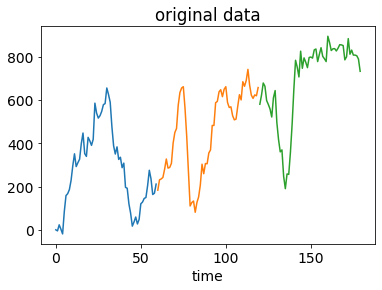

data:  20


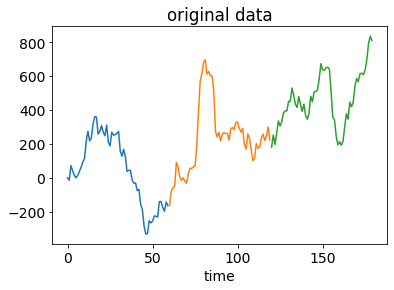

data:  50


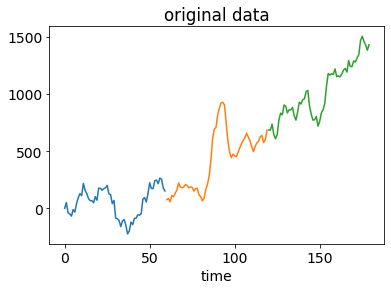

data:  100


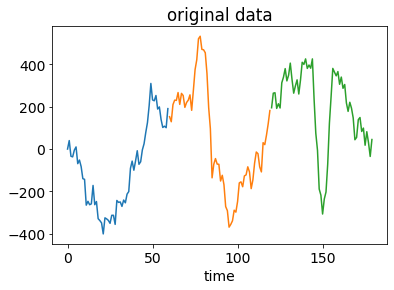

data:  150


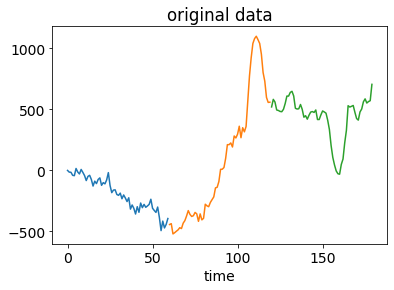

data:  200


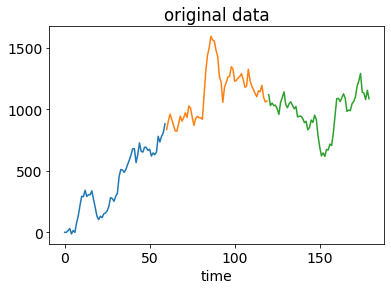

data:  250


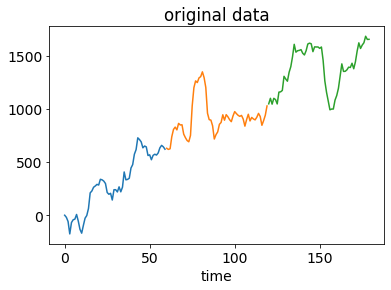

data:  300


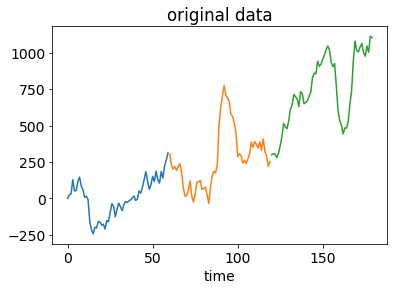

data:  400


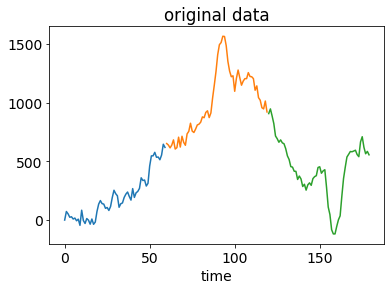

data:  500


In [2]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

dim = [20, 50, 100, 150, 200, 250, 300, 400, 500]
x = [np.zeros(shape=(i, 60)) for i in dim]
y = [np.zeros(shape=(i    )) for i in dim]

for i, n in enumerate(dim):
    str0 = f'ts_L60_Z12_A500_DX50_bias5_N{n}.dat'
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0
    x[i] = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x[i]), len(x[i][0])

    Show_data(x[i],L,"original data")

    # note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
    y[i] = np.loadtxt(fnamey, dtype=int)
    n_class = 3    #  = len(np.unique(y))
    print('data: ',N)

### (do not) Rescale data
We know that the average value of a sample is not relevant: let's see if XGBoost works if we do not remove such average and we do not standardize data

In [3]:
RESCALE=False
if RESCALE:
    xm = []
    #remove average value of each sample from its values
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    #rescale (crude version, variance should be used)
    x = x/400

    Show_data(x,L,"rescaled data")

## TSFRESH: extract features

Input data format: DATAFRAME

first column $\to$ id of the sample 

second column $\to$  id of the time step

third column $\to$ value of the feature of _id_-sample at _id_-step

For more: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html

In [4]:
#get df
df = [get_df(x[i]) for i in range(len(dim))] 

#check that last columns, if reshaped is equal to x
#df_to_array = df.values[:,-1].reshape(x.shape[0],x.shape[1])
#sum of different values: should be 0
#print('Differences:',np.sum(df_to_array != x))

df[0]

id  time   value
0      0     0     0.0
1      0     1    -5.0
2      0     2    23.0
3      0     3     3.0
4      0     4   -19.0
...   ..   ...     ...
1195  19    55  4754.0
1196  19    56  4734.0
1197  19    57  4722.0
1198  19    58  4772.0
1199  19    59  4746.0

[1200 rows x 3 columns]

In [5]:
#extract features
x_features = [extract_features(df[i], #our dataframe
                               column_id='id', #sample id, from 0 to N
                               column_sort='time', #timestep, from 0 to t
                               column_kind=None, #we have only one feature
                               column_value='value', #value of input 
                               n_jobs=4) #number of cores
              for i in range(len(dim))]

Feature Extraction: 100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


In [6]:
#look at x_features
x_features[8]

value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                               1.0                       0.0   
1                                               1.0                       0.0   
2                                               1.0                       0.0   
3                                               1.0                       0.0   
4                                               1.0                       0.0   
..                                              ...                       ...   
495                                             1.0                       0.0   
496                                             1.0                       0.0   
497                                             1.0                       0.0   
498                                             1.0                       0.0   
499                                             1.0                       0.0   

     value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                         0.0                   1.0            11882.0   
1                         0.0                   1.0            60382.0   
2                         1.0                   1.0            26468.0   
3                         0.0                   1.0            14267.0   
4                         0.0                   1.0            43080.0   
..                        ...                   ...                ...   
495                       0.0                   1.0          8554380.0   
496                       0.0                   1.0          8577507.0   
497                       0.0                   1.0          8613021.0   
498                       0.0                   1.0          8630141.0   
499                       0.0                   1.0          8642650.0   

     value__abs_energy  value__mean_abs_change  value__mean_change  \
0         4.540860e+06               40.864407           10.491525   
1         6.525805e+07               54.220339            4.559322   
2         1.524384e+07               48.762712           -5.949153   
3         6.202743e+06               33.135593           -5.169492   
4         3.728399e+07               52.440678           12.677966   
..                 ...                     ...                 ...   
495       1.219624e+12               37.118644           -1.796610   
496       1.226232e+12               51.000000            8.423729   
497       1.236405e+12               47.406780           10.525424   
498       1.241323e+12               33.288136           -0.067797   
499       1.244924e+12               42.135593            3.186441   

     value__mean_second_derivative_central  value__median  ...  \
0                                -0.862069          156.0  ...   
1                                -0.689655          985.5  ...   
2                                -0.594828          450.0  ...   
3                                 0.551724          186.5  ...   
4                                 0.000000          710.5  ...   
..                                     ...            ...  ...   
495                               0.818966       142564.5  ...   
496                               0.284483       143092.0  ...   
497                              -0.103448       143502.0  ...   
498                              -0.689655       143842.5  ...   
499                               0.543103       144035.0  ...   

     value__permutation_entropy__dimension_6__tau_1  \
0                                          3.830896   
1                                          3.725480   
2                                          3.337359   
3                                          3.846587   
4                                          3.589413   
..                                              ...   
495                                        3.856101   
496                                        3.600712   
497           

In [7]:
#remove columns with NaN or inf
for i in range(len(dim)):
    x_features[i].replace([np.inf, -np.inf], np.nan)
    x_features[i] = x_features[i].dropna(axis='columns')

### Split train/val

In [8]:
#split data into training and validation

perc_train=0.8
N_train=[int(perc_train*len(x[i]))  for i in range(len(dim))]
x_train=[x_features[i][:N_train[i]] for i in range(len(dim))]
y_train=[y[i][:N_train[i]]          for i in range(len(dim))]
x_val  =[x_features[i][N_train[i]:] for i in range(len(dim))]
y_val  =[y[i][N_train[i]:]          for i in range(len(dim))]
N_val  =[len(x_val[i])              for i in range(len(dim))]

for i in range(len(dim)):
    print(i, 'N_train=',N_train[i],'  N_val=',N_val[i],'  n_class=',n_class)

0 N_train= 16   N_val= 4   n_class= 3
1 N_train= 40   N_val= 10   n_class= 3
2 N_train= 80   N_val= 20   n_class= 3
3 N_train= 120   N_val= 30   n_class= 3
4 N_train= 160   N_val= 40   n_class= 3
5 N_train= 200   N_val= 50   n_class= 3
6 N_train= 240   N_val= 60   n_class= 3
7 N_train= 320   N_val= 80   n_class= 3
8 N_train= 400   N_val= 100   n_class= 3


In [9]:
#look at x_train
x_train[0]

value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              1.0                       0.0   
3                                              1.0                       0.0   
4                                              1.0                       0.0   
5                                              1.0                       0.0   
6                                              1.0                       1.0   
7                                              1.0                       0.0   
8                                              1.0                       0.0   
9                                              1.0                       0.0   
10                                             1.0                       0.0   
11                                             1.0                       0.0   
12                                             1.0                       0.0   
13                                             1.0                       0.0   
14                                             1.0                       0.0   
15                                             1.0                       0.0   

    value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                        0.0                   1.0            16750.0   
1                        0.0                   1.0            27302.0   
2                        0.0                   1.0            41650.0   
3                        0.0                   1.0            37428.0   
4                        0.0                   1.0            58260.0   
5                        0.0                   1.0            89485.0   
6                        0.0                   1.0           120965.0   
7                        0.0                   1.0           130625.0   
8                        0.0                   1.0           153223.0   
9                        0.0                   1.0           181771.0   
10                       0.0                   1.0           175775.0   
11                       0.0                   1.0           171731.0   
12                       0.0                   1.0           195675.0   
13                       0.0                   1.0           231510.0   
14                       0.0                   1.0           224478.0   
15                       0.0                   1.0           227834.0   

    value__abs_energy  value__mean_abs_change  value__mean_change  \
0           6729150.0               43.101695            3.576271   
1          14556188.0               44.000000            8.033898   
2          30904786.0               45.491525            2.576271   
3          23935100.0               44.372881           -2.169492   
4          60723594.0               54.593220           10.728814   
5         137140845.0               45.644068           10.830508   
6         244298969.0               39.559322            3.152542   
7         287046061.0               53.457627            5.050847   
8         394072457.0               52.220339           11.169492   
9         551550183.0               41.016949           -2.033898   
10        516480085.0               48.915254           -1.762712   
11        492860205.0               46.203390            3.288136   
12        640327083.0               35.694915            8.338983   
13        895581132.0               51.830508            4.983051   
14        842234510.0               51.186441            4.169492   
15        867055934.0               32.593220           -8.627119   

    value__mean_second_derivative_central  value__median  ...  \
0                                0.405172          289.5  ...   
1                               -0.086207          509.5  ...   
2                               

## XGB

In [10]:
#for i in range(len(dim)):
#    print(np.any(np.isinf(x_train[i])))

#0,3,6
for i in range(len(dim)):
    #print(np.any(np.isinf(x_train[i])))
    #for x in x_train[i].columns:
    #    if np.any(np.isinf(x_train[i][x])):
    #        print(x)
    x_train[i].drop(columns=['value__sample_entropy'],inplace=True)
    x_val[i].drop(columns=['value__sample_entropy'],inplace=True)

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = [XGBClassifier(**params) for i in range(len(dim))]
scaler = StandardScaler()
x_trainScaled = [scaler.fit_transform(x_train[i]) for i in range(len(dim))]

#fit
for i in range(len(dim)):
    model[i].fit(x_train[i].values,y_train[i])

[19:21:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

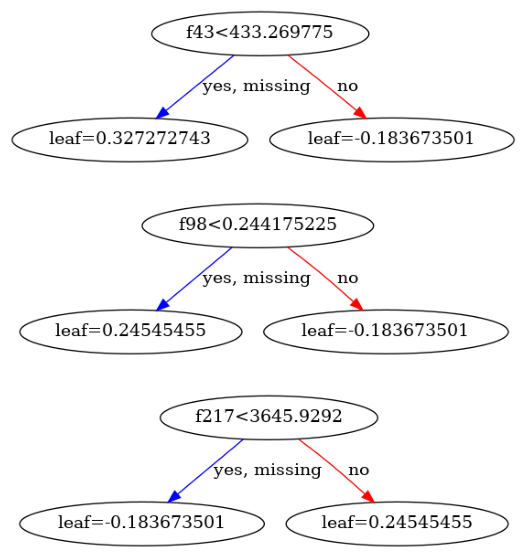

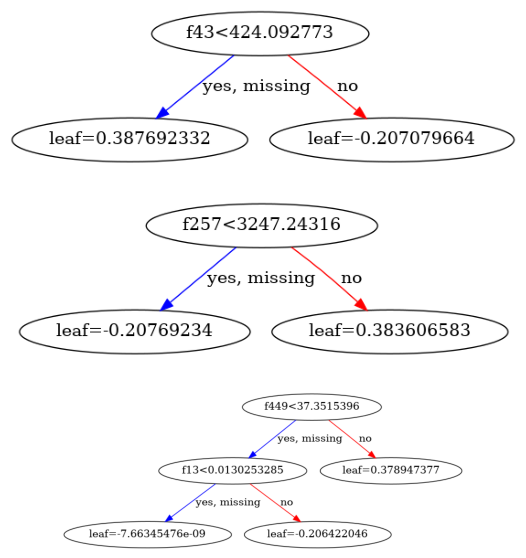

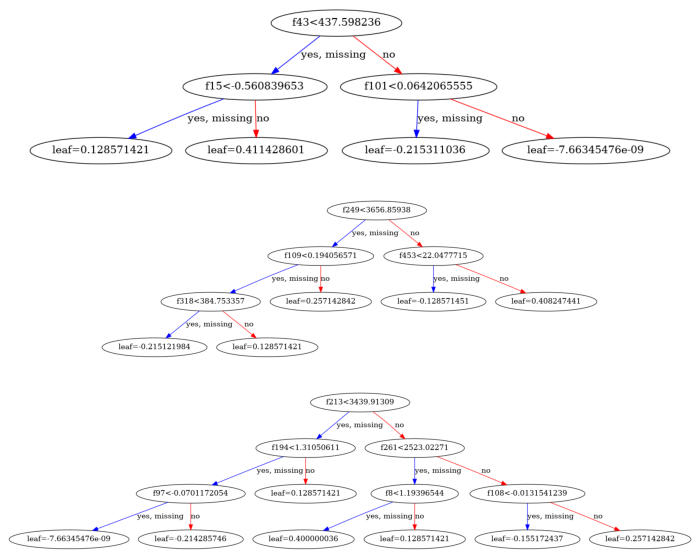

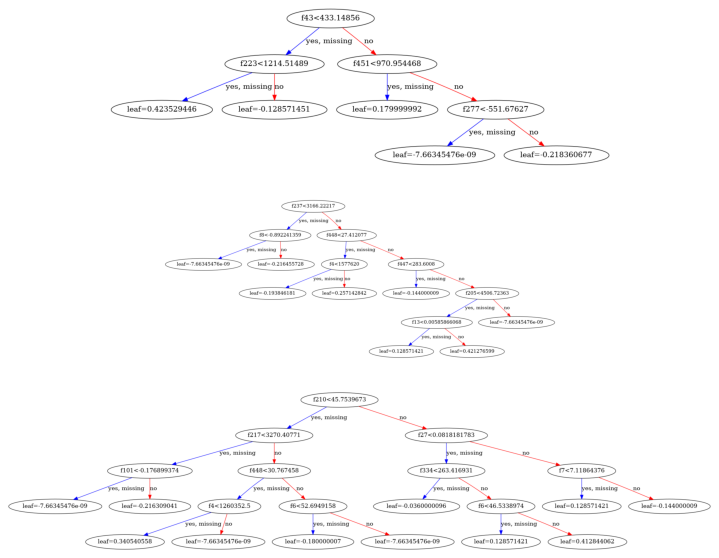

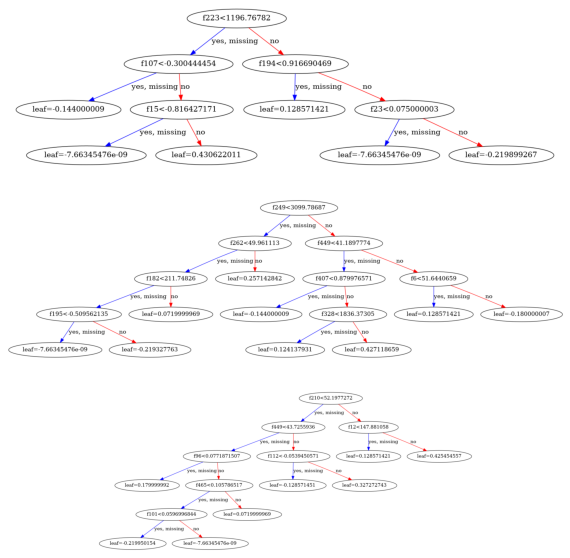

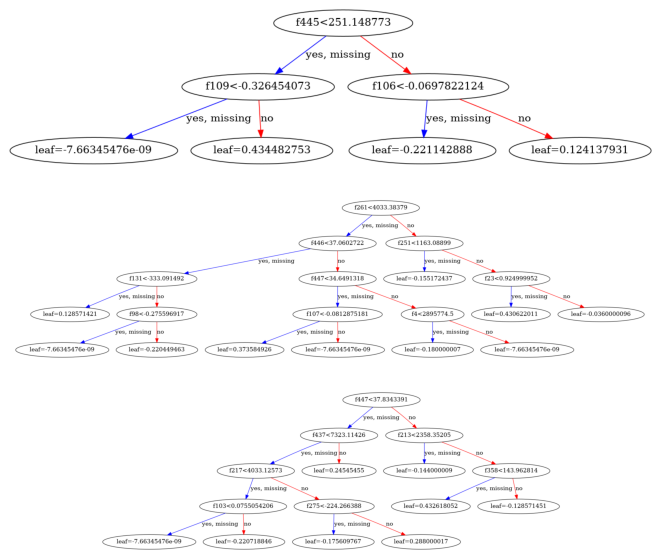

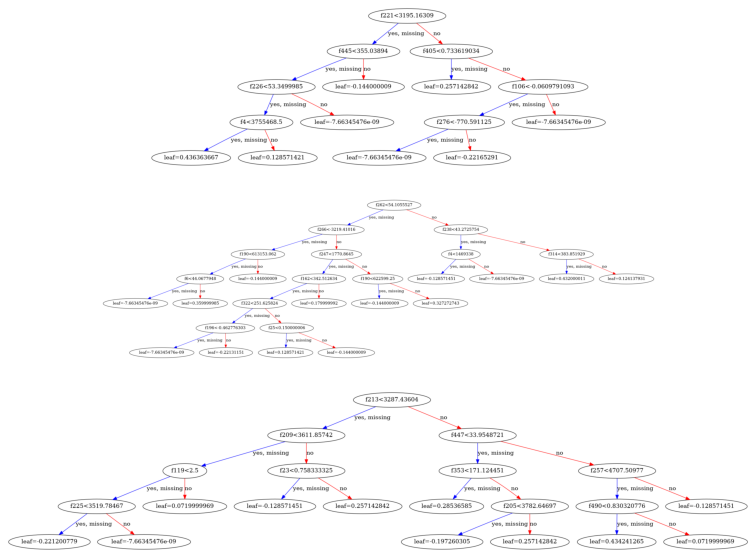

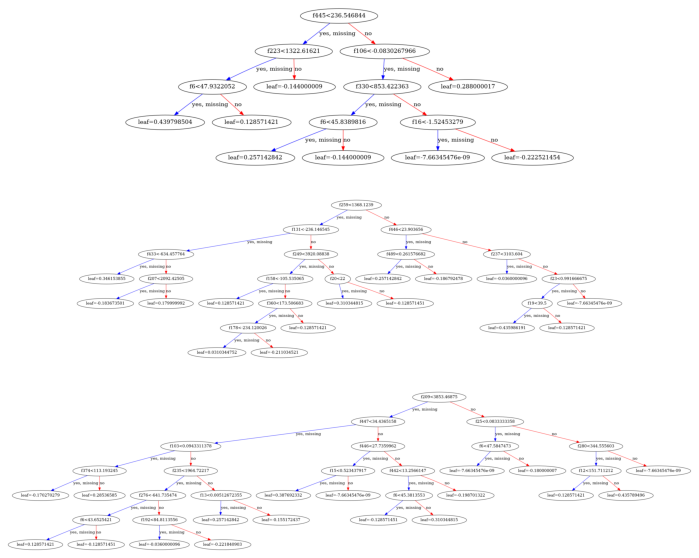

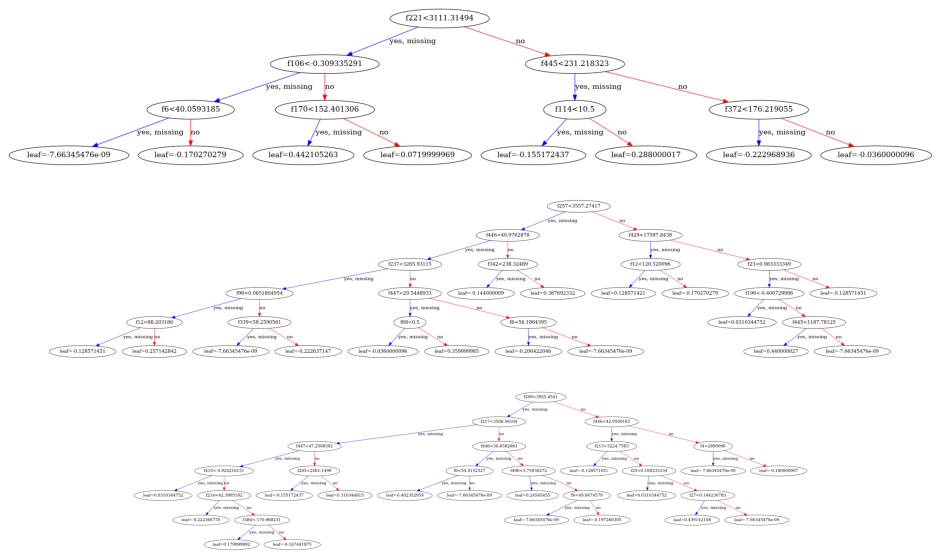

In [12]:
#plot tree


for j in range(len(dim)):
    fig, AX = plt.subplots(3,1,figsize=(30, 10))
    for i in range(3):
        ax=AX[i]
        plot_tree(model[j], num_trees=i, ax=ax)
    
    fig.savefig("DATA/trees-time-ser{j}.png", dpi=300, pad_inches=0.02)

In [13]:
from sklearn.metrics import accuracy_score

#predict labels on training set
y_pred_train = [model[i].predict(x_train[i]) for i in range(len(dim))]
#predict labels on validation set
y_pred_val = [model[i].predict(x_val[i]) for i in range(len(dim))]

y_pred_val_soft = [model[i].predict_proba(x_val[i]) for i in range(len(dim))]



#compute accuracies
acc_train = [accuracy_score(y_train[i],y_pred_train[i]) for i in range(len(dim))]
acc_val   = [accuracy_score(y_val[i],y_pred_val[i]) for i in range(len(dim))]

#print accuracies
for i in range(len(dim)):
    print(i,': Training accuracy:',acc_train[i])
    print(i,': Validation accuracy:',acc_val[i])

0 : Training accuracy: 1.0
0 : Validation accuracy: 0.75
1 : Training accuracy: 1.0
1 : Validation accuracy: 0.5
2 : Training accuracy: 1.0
2 : Validation accuracy: 0.85
3 : Training accuracy: 1.0
3 : Validation accuracy: 0.9666666666666667
4 : Training accuracy: 1.0
4 : Validation accuracy: 0.9
5 : Training accuracy: 1.0
5 : Validation accuracy: 0.9
6 : Training accuracy: 1.0
6 : Validation accuracy: 0.9
7 : Training accuracy: 1.0
7 : Validation accuracy: 0.95
8 : Training accuracy: 1.0
8 : Validation accuracy: 0.92


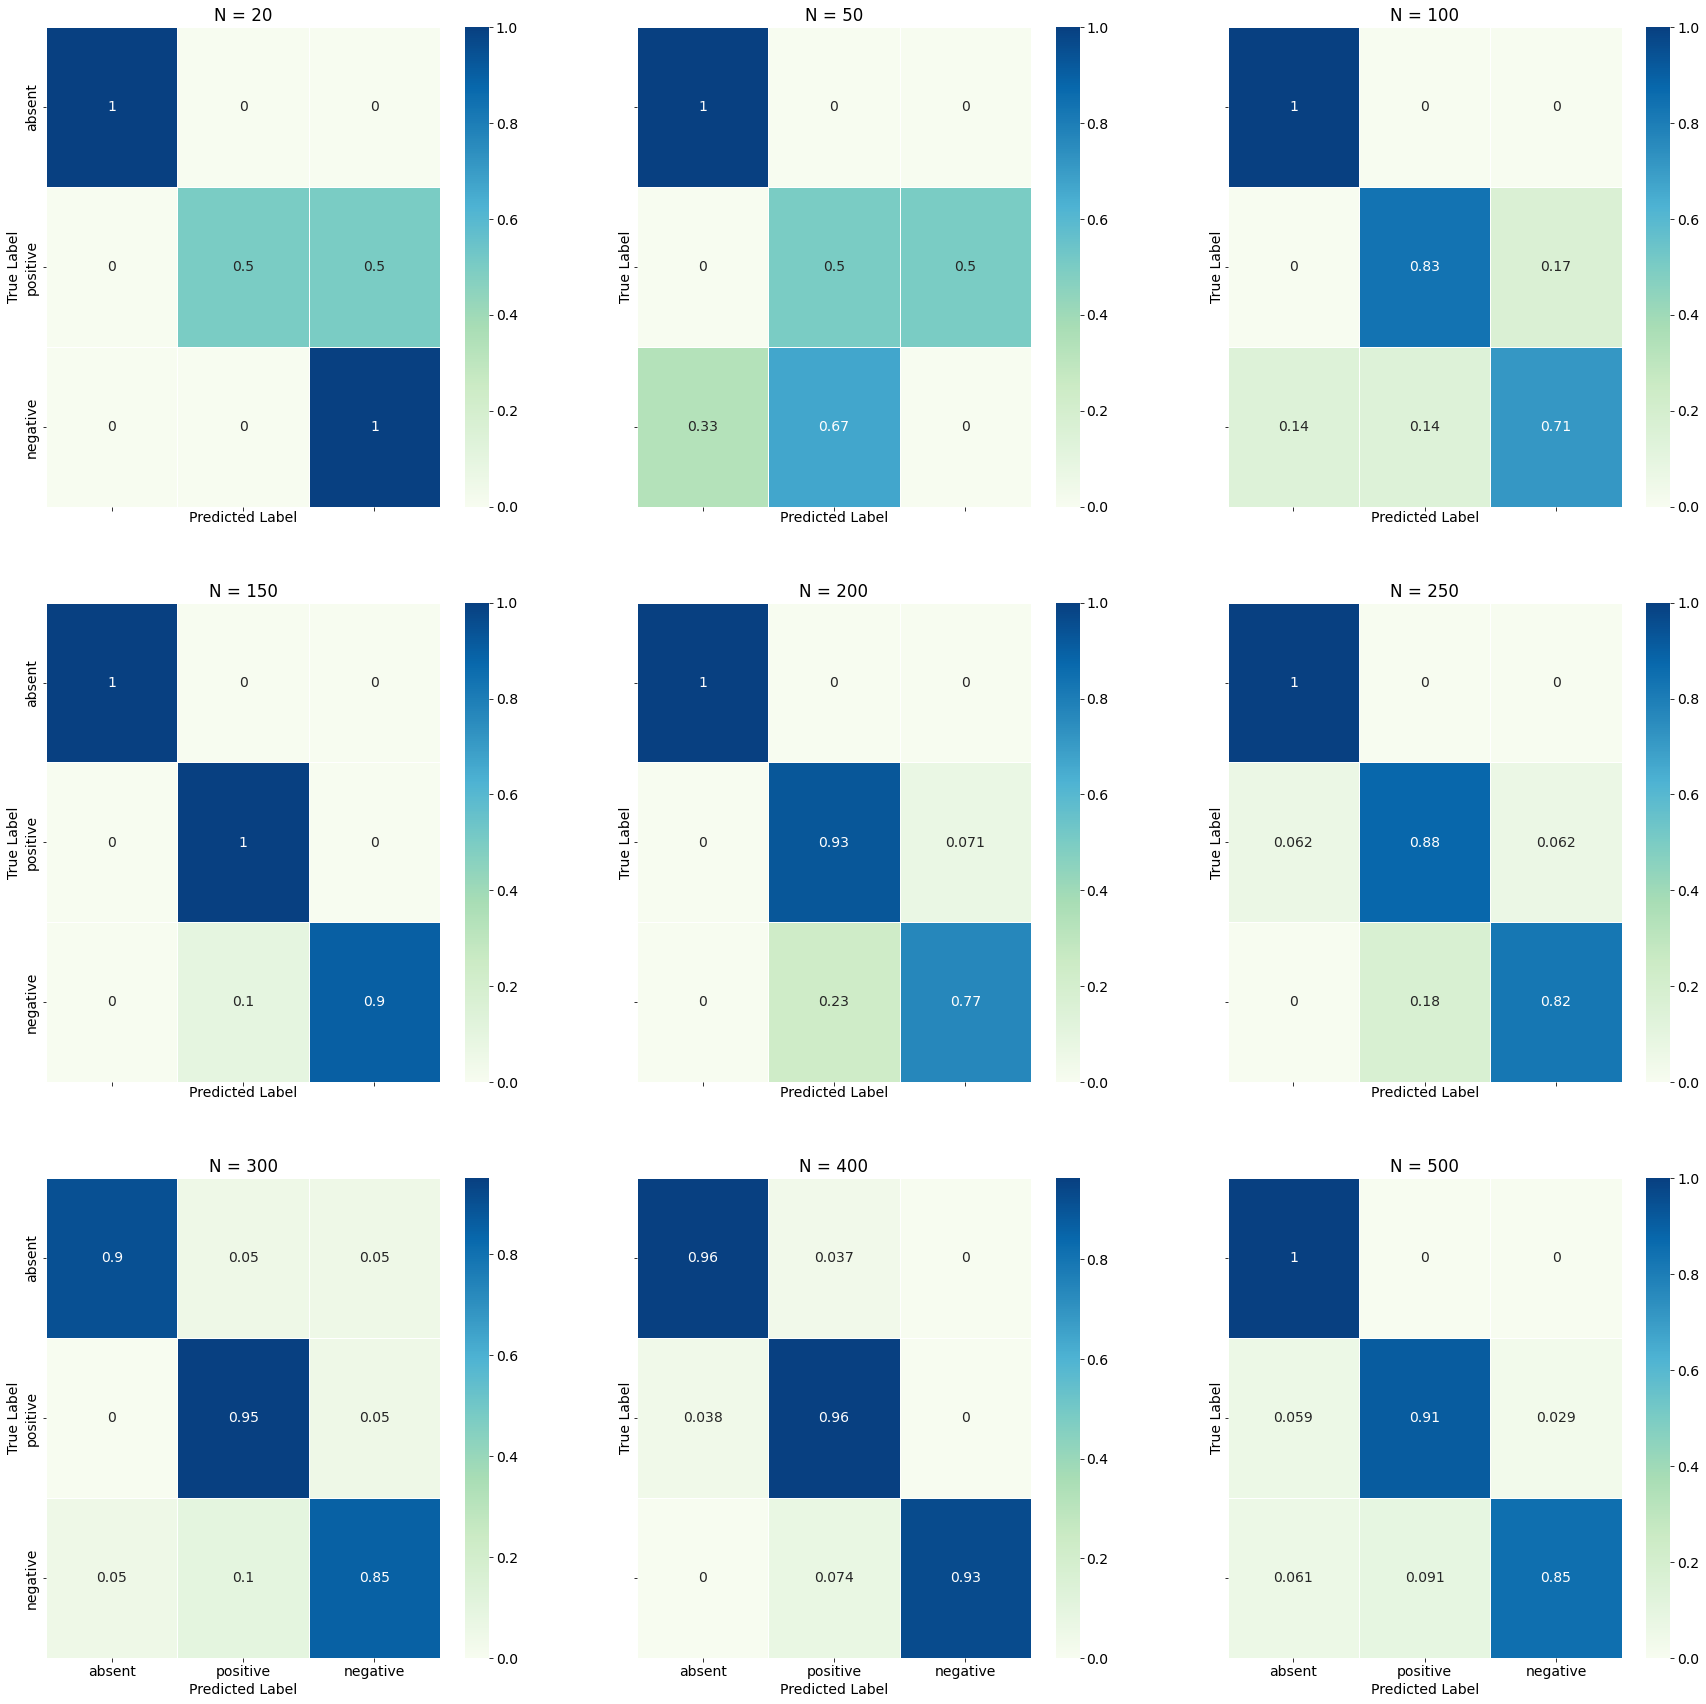

In [14]:
import seaborn as sns
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(ax, validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions, normalize='true')
    #plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                #fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap,
                ax = ax)
    ax.set_title(label)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

y_pred_val = [model[i].predict(x_val[i]) for i in range(len(dim))]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,30), sharex=True, sharey=True)
col = row = 0
for i, N in enumerate(dim):
    show_confusion_matrix(ax[row, col], y_val[i], y_pred_val[i], f'N = {N}')
    col += 1
    if col == 3:
        col = 0
        row += 1
plt.show()

### Defininition of the CNN

In [15]:
from tensorflow.keras.utils import to_categorical

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
import pandas as pd

from keras import initializers, regularizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from scipy import stats
import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from keras import initializers, regularizers
import tensorflow.random as tf_r
tf_r.set_seed(12345)

In [16]:
"""Rescaling the Data"""

def reg_scale(x):
    return x/400

def std_scale(x, N):
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    return x/np.sqrt(x.var())

def norm_scale(x):
    return (x - np.min(x, axis=0)) / np.abs(np.max(x, axis=0) - np.min(x, axis=0))

def log_scale(x): 
    x = x - np.min(x, axis=0) + 0.0000001 #shifting the data to be greater than 0
    return np.log10(x)

N = [len(x[i])     for i in range(len(dim))]
L = [len(x[i][0]) for i in range(len(dim))]

#x_CNN     =  [reg_scale( x[i]) for i in range(len(dim))]
x_CNN     =  [std_scale( x[i], N[i]) for i in range(len(dim))]
#x_CNN     =  [norm_scale(x[i]) for i in range(len(dim))]
#x_CNN     =  [log_scale( x[i]) for i in range(len(dim))]

perc_train=0.8
N_train_CNN=[int(perc_train*len(x[i]))  for i in range(len(dim))]
x_train_CNN = [x[i][:N_train[i]] for i in range(len(dim))]
y_train_CNN = [to_categorical(y[i][:N_train[i]], 3) for i in range(len(dim))]
x_val_CNN = [x[i][N_train[i]:] for i in range(len(dim))]
y_val_CNN = [to_categorical(y[i][N_train[i]:],3) for i in range(len(dim))]
N_val_CNN = [len(x_val[i]) for i in range(len(dim))]
for i in range(len(dim)):
    print(i, 'N_train=',N_train_CNN[i],'  N_val=',N_val_CNN[i],'  L=',L[i],'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
for i in range(len(dim)):
    x_train_CNN[i] = x_train_CNN[i].reshape(x_train_CNN[i].shape[0], L[i], 1)
    x_val_CNN[i] =  x_val_CNN[i].reshape(x_val_CNN[i].shap# pattern parameters: Z=nr of steps, A=amplitude
Z=12
A=500

# number of data samples
for N in [20, 50, 100, 150, 200, 250, 300, 400, 500]:
    # size of each sample of the timeseries
    L=60
    # step parameters: introduce small positive bias 
    DX = 50
    bias = 5

    y = [0] * N
    x = [[0] * L for i in range(N)]
    for i in range(N):

        if i>0:
            x[i][0] = x[i-1][-1] + jump(bias,DX)
        
        for j in range(1,L):
            x[i][j] = x[i][j-1] + jump(bias,DX)
            
        y[i] = i%3 
        ##y[i] = random.randint(0,2)
        if y[i]>0:
            j0 = np.random.randint(0,L-1-Z)
            ###print(i,j0,j1)
            sign = 3-2*y[i]
            for j in range(Z):
                x[i][j0+j] += sign*pattern(j,Z,A)e[0], L[i], 1)
input_shape = [(L[i], 1) for i in range(len(dim))]

0 N_train= 16   N_val= 4   L= 60   n_class= 3
1 N_train= 40   N_val= 10   L= 60   n_class= 3
2 N_train= 80   N_val= 20   L= 60   n_class= 3
3 N_train= 120   N_val= 30   L= 60   n_class= 3
4 N_train= 160   N_val= 40   L= 60   n_class= 3
5 N_train= 200   N_val= 50   L= 60   n_class= 3
6 N_train= 240   N_val= 60   L= 60   n_class= 3
7 N_train= 320   N_val= 80   L= 60   n_class= 3
8 N_train= 400   N_val= 100   L= 60   n_class= 3


In [17]:
def create_CNN(reg, lam, init, kernel_size, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=kernel_size[0], 
                    kernel_initializer=init, 
                    kernel_regularizer=reg(lam),
                    activation='relu', 
                    input_shape=input_shape))
    model.add(Conv1D(filters=8, kernel_size=kernel_size[1], 
                    kernel_initializer=init, 
                    kernel_regularizer=reg(lam),
                    activation='relu', 
                    input_shape=input_shape))
    model.add(Conv1D(filters=4, kernel_size=kernel_size[2], 
                    kernel_initializer=init, 
                    kernel_regularizer=reg(lam),
                    activation='relu', 
                    input_shape=input_shape)) 

    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, 
    optimizer = "adam", metrics = ["accuracy"])
    
    return model

init_best        = 'GlorotUniform' #is GlorotUniform
reg_best         = regularizers.L1 #best_result.param_reg.values[0]
lam_best         = 0
kernel_size_best = [5,5,5] #best_result.param_kernel_size.values[0]

BATCH_SIZE = 5
EPOCHS = 100

model_best = [create_CNN(reg_best, lam_best, init_best, kernel_size_best, input_shape[i]) for i in range(len(dim))]

fit_CNN = [model_best[i].fit(x_train_CNN[i],y_train_CNN[i],
                             epochs=EPOCHS,batch_size=BATCH_SIZE,
                             validation_data=(x_val_CNN[i], y_val_CNN[i]),
                             verbose=2, shuffle=True) for i in range(len(dim))]


32/32 - 1s - loss: 18.4936 - accuracy: 0.3625 - val_loss: 9.7375 - val_accuracy: 0.4750 - 836ms/epoch - 26ms/step
Epoch 2/100
32/32 - 0s - loss: 8.6048 - accuracy: 0.4250 - val_loss: 4.9832 - val_accuracy: 0.5000 - 105ms/epoch - 3ms/step
Epoch 3/100
32/32 - 0s - loss: 5.7089 - accuracy: 0.4563 - val_loss: 3.7557 - val_accuracy: 0.5000 - 86ms/epoch - 3ms/step
Epoch 4/100
32/32 - 0s - loss: 4.3687 - accuracy: 0.4938 - val_loss: 2.8156 - val_accuracy: 0.5000 - 118ms/epoch - 4ms/step
Epoch 5/100
32/32 - 0s - loss: 3.9675 - accuracy: 0.5312 - val_loss: 2.4724 - val_accuracy: 0.5500 - 98ms/epoch - 3ms/step
Epoch 6/100
32/32 - 0s - loss: 3.0541 - accuracy: 0.4875 - val_loss: 2.2228 - val_accuracy: 0.5250 - 95ms/epoch - 3ms/step
Epoch 7/100
32/32 - 0s - loss: 2.4419 - accuracy: 0.5312 - val_loss: 2.2553 - val_accuracy: 0.4000 - 98ms/epoch - 3ms/step
Epoch 8/100
32/32 - 0s - loss: 2.3831 - accuracy: 0.4875 - val_loss: 2.4347 - val_accuracy: 0.4000 - 97ms/epoch - 3ms/step
Epoch 9/100
32/32 - 0s 

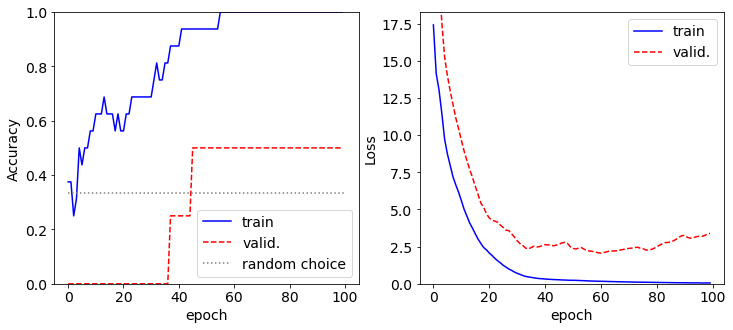

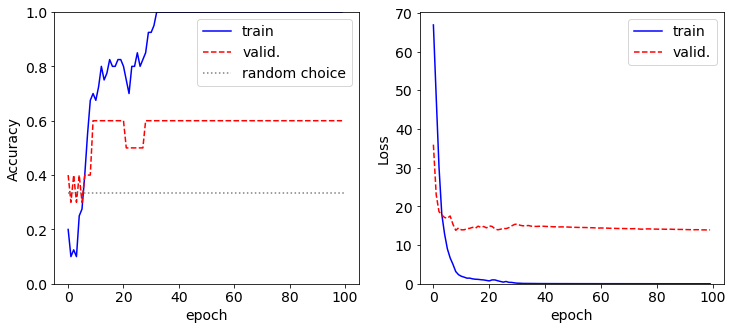

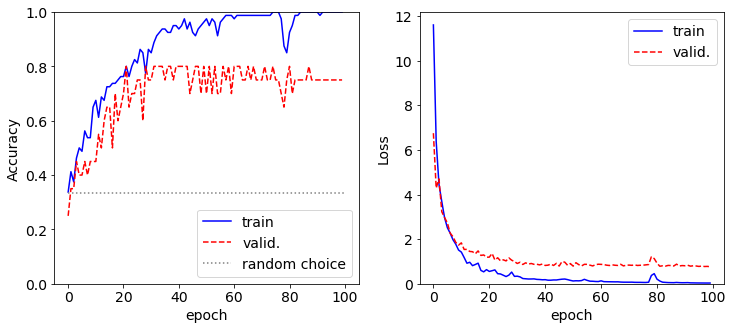

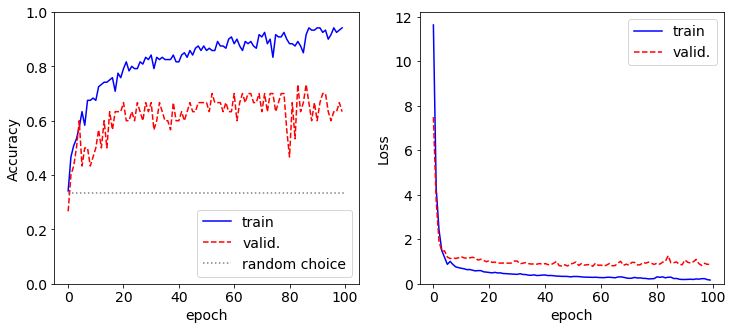

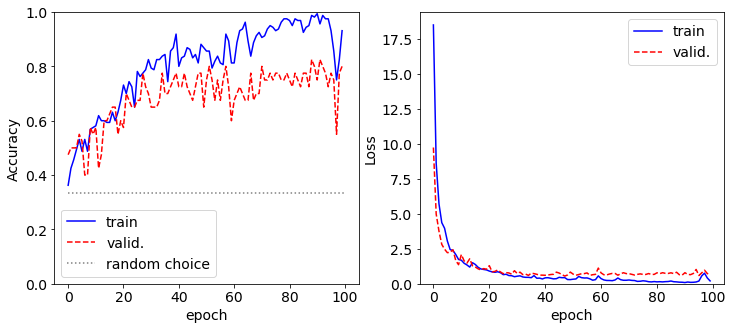

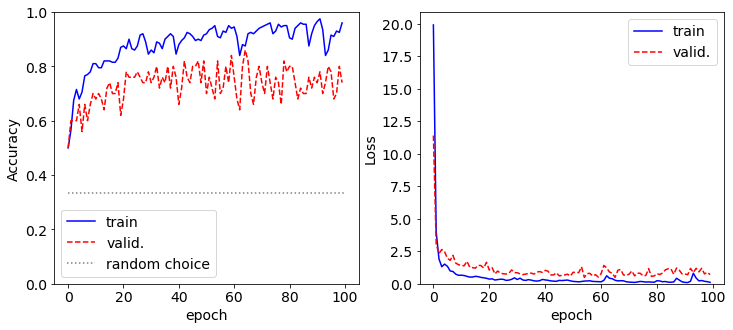

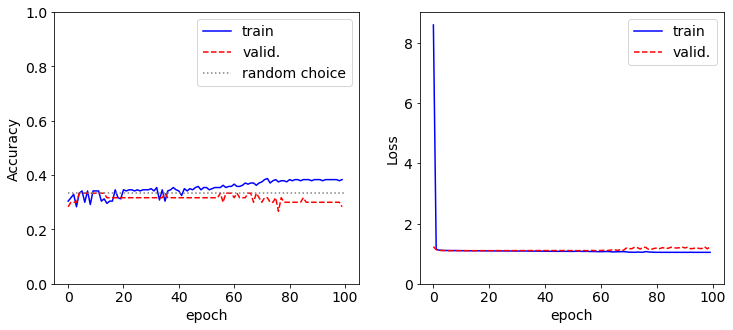

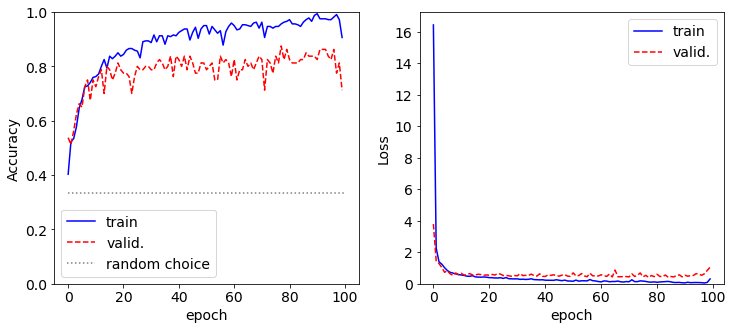

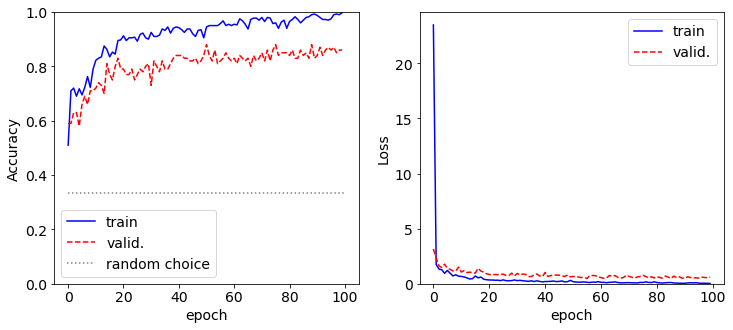

In [18]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

for i in range(len(dim)):
    Show_history(fit_CNN[i])

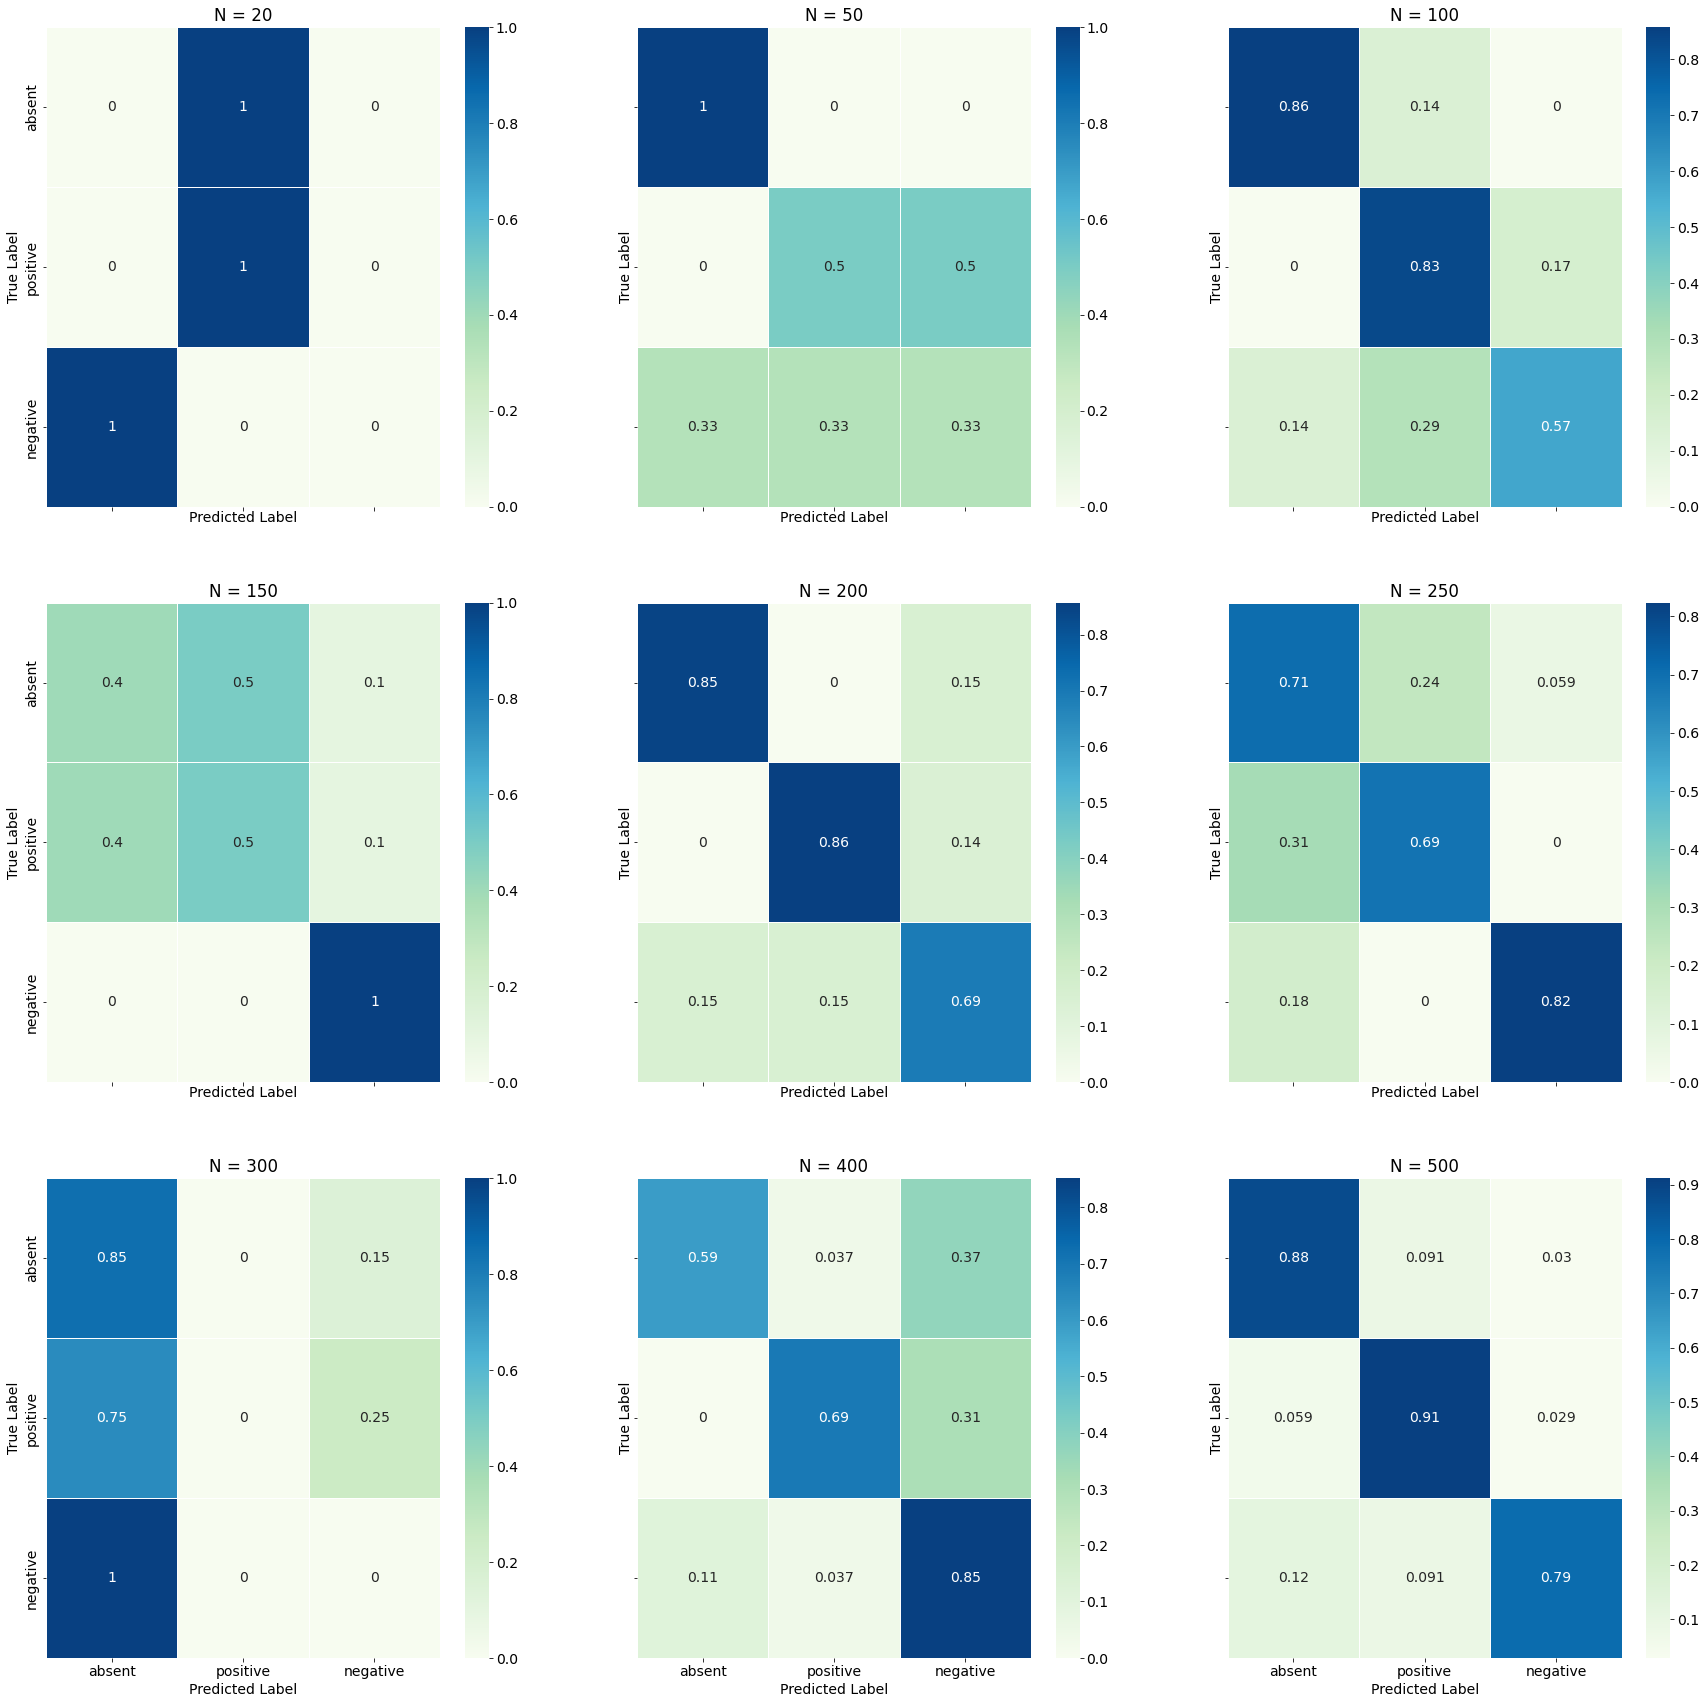

In [19]:
LABELS = ["absent","positive","negative"]
cmap="GnBu"

y_pred_val_CNN = [model_best[i].predict(x_val_CNN[i]) for i in range(len(dim))]

# Take the class with the highest probability from the val predictions
max_y_pred_val_CNN = [np.argmax(y_pred_val_CNN[i], axis=1) for i in range(len(dim))]
max_y_val_CNN      = [np.argmax(y_val_CNN[i], axis=1) for i in range(len(dim))]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,30), sharex=True, sharey=True)
col = row = 0
for i, N in enumerate(dim):
    show_confusion_matrix(ax[row, col], max_y_val_CNN[i], max_y_pred_val_CNN[i], f'N = {N}')
    col += 1
    if col == 3:
        col = 0
        row += 1
plt.show()

### Multiple iterations to take average and std

In [42]:
# function for the random step, using lambda construction
# int() for cleaner look and for mimicing a detector with finite resolution
jump = lambda drift, stdev: int(np.random.normal(drift,stdev))
def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

    # pattern parameters: Z=nr of steps, A=amplitude
Z=12
A=500

# number of samples to be used
dim = [20, 50, 100, 150, 200, 250, 300, 400, 500]

# size of each sample of the timeseries
L=60
# step parameters: introduce small positive bias 
DX = 50
bias = 5

iterations = 5
train_accuracy =     val_accuracy     = np.zeros(shape=(len(dim), iterations))
train_accuracy_CNN = val_accuracy_CNN = np.zeros(shape=(len(dim), iterations))

for z in range(iterations):
    x = np.array([np.zeros(shape=(i, 60)) for i in range(len(dim))])
    y = np.array([np.zeros(shape=(i    )) for i in range(len(dim))])
    # number of data samples
    for k, N in enumerate(dim):
        y[k] = [0] * N
        x[k] = np.array([[0] * L for i in range(N)])
        for i in range(N):
            if i>0:
                x[k][i][0] = x[k][i-1][-1] + jump(bias,DX)
            for j in range(1,L):
                x[k][i][j] = x[k][i][j-1] + jump(bias,DX)
            y[k][i] = i%3 
            if y[k][i]>0:
                j0 = np.random.randint(0,L-1-Z)
                sign = 3-2*y[k][i]
                for j in range(Z):
                    x[k][i][j0+j] += sign*pattern(j,Z,A)
    df = [get_df(x[i]) for i in range(len(dim))]
    x_features = [extract_features(df[i], #our dataframe
                               column_id='id', #sample id, from 0 to N
                               column_sort='time', #timestep, from 0 to t
                               column_kind=None, #we have only one feature
                               column_value='value', #value of input 
                               n_jobs=4) #number of cores
                  for i in range(len(dim))]
    #remove columns with NaN or inf
    for i in range(len(dim)):
        x_features[i].replace([np.inf, -np.inf], np.nan)
        x_features[i] = x_features[i].dropna(axis='columns')
    #split data into training and validation

    perc_train=0.8
    N_train=[int(perc_train*len(x[i]))  for i in range(len(dim))]
    x_train=[x_features[i][:N_train[i]] for i in range(len(dim))]
    y_train=[y[i][:N_train[i]]          for i in range(len(dim))]
    x_val  =[x_features[i][N_train[i]:] for i in range(len(dim))]
    y_val  =[y[i][N_train[i]:]          for i in range(len(dim))]
    N_val  =[len(x_val[i])              for i in range(len(dim))]


    for i in range(len(dim)):
        x_train[i].drop(columns=['value__sample_entropy'],inplace=True)
        x_val[i].drop(columns=['value__sample_entropy'],inplace=True)

    # reproducibility
    np.random.seed(12345)

    #define parameters for xgboost
    params = {'max_depth':6,'min_child_weight':1,\
            'learning_rate':0.3,'use_label_encoder':False}

    #build model with given params
    model = [XGBClassifier(**params) for i in range(len(dim))]
    scaler = StandardScaler()
    x_trainScaled = [scaler.fit_transform(x_train[i]) for i in range(len(dim))]

    #fit
    for i in range(len(dim)):
        model[i].fit(x_train[i].values,y_train[i])

    # plot tree here if needed

    #predict labels on training set
    y_pred_train = [model[i].predict(x_train[i]) for i in range(len(dim))]
    #predict labels on validation set
    y_pred_val = [model[i].predict(x_val[i]) for i in range(len(dim))]
    y_pred_val_soft = [model[i].predict_proba(x_val[i]) for i in range(len(dim))]

    #compute accuracies
    train_accuracy[:, z] = [accuracy_score(y_train[i],y_pred_train[i]) for i in range(len(dim))]
    val_accuracy[:, z]   = [accuracy_score(y_val[i],y_pred_val[i])     for i in range(len(dim))]

results_fits = pd.DataFrame({'validation':  np.concatenate([train_accuracy[i,:]                for i in range(len(dim))]),
                             'training':    np.concatenate([val_accuracy[i,:]                  for i in range(len(dim))]),
                             'group':       np.concatenate([np.repeat(f'{dim[i]}', iterations) for i in range(len(dim))])})
results_fits.to_csv('XGB_2.csv')


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Feature Extraction:  40%|████      | 8/20 [00:03<00:05,  2.02it/s]Process ForkPoolWorker-322:
Process ForkPoolWorker-320:
Process ForkPoolWorker-319:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 297, in _bo

KeyboardInterrupt: 

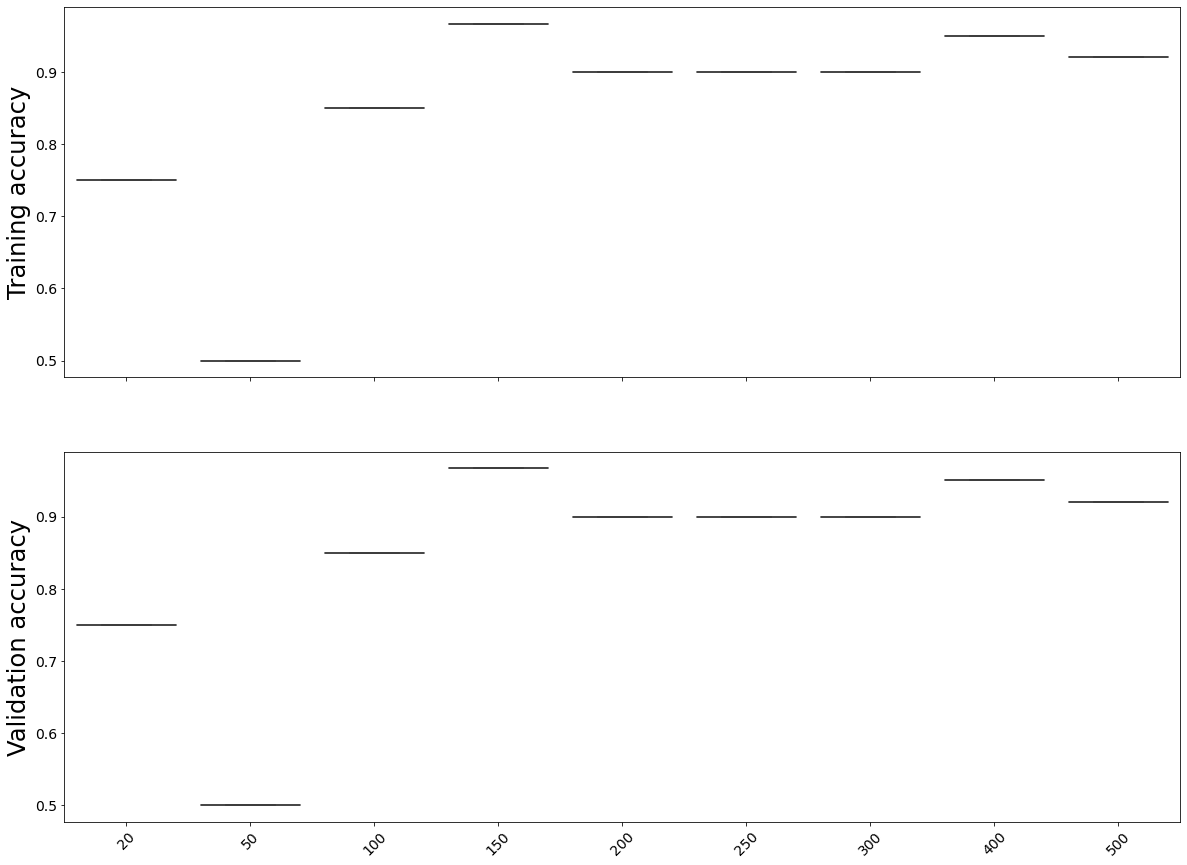

In [40]:
fig, ax = plt.subplots(nrows = 2, figsize=(20,15), sharex=True)

g = sns.boxplot(x='group', y='training', data=results_fits, ax = ax[0] )
ax[0].set_xlabel('')
ax[0].set_ylabel('Training accuracy', fontsize='xx-large')
ax[0].tick_params(axis='x', labelrotation= 45)

#fig.savefig('figures/ex1_boxplot_training_20.pdf')


#fig, ax = plt.subplots(ncols = 1, figsize=(15,10))

g = sns.boxplot(x='group', y='validation', data=results_fits, ax = ax[1] )
ax[1].set_xlabel('')
ax[1].set_ylabel('Validation accuracy', fontsize='xx-large')
ax[1].tick_params(axis='x', labelrotation= 45)

In [39]:
results_fits

validation  training group
0     0.750000  0.750000    20
1     0.750000  0.750000    20
2     0.750000  0.750000    20
3     0.750000  0.750000    20
4     0.750000  0.750000    20
5     0.500000  0.500000    50
6     0.500000  0.500000    50
7     0.500000  0.500000    50
8     0.500000  0.500000    50
9     0.500000  0.500000    50
10    0.850000  0.850000   100
11    0.850000  0.850000   100
12    0.850000  0.850000   100
13    0.850000  0.850000   100
14    0.850000  0.850000   100
15    0.966667  0.966667   150
16    0.966667  0.966667   150
17    0.966667  0.966667   150
18    0.966667  0.966667   150
19    0.966667  0.966667   150
20    0.900000  0.900000   200
21    0.900000  0.900000   200
22    0.900000  0.900000   200
23    0.900000  0.900000   200
24    0.900000  0.900000   200
25    0.900000  0.900000   250
26    0.900000  0.900000   250
27    0.900000  0.900000   250
28    0.900000  0.900000   250
29    0.900000  0.900000   250
30    0.900000  0.900000   300
31    0.900000  0.900000   300
32    0.900000  0.900000   300
33    0.900000  0.900000   300
34    0.900000  0.900000   300
35    0.950000  0.950000   400
36    0.950000  0.950000   400
37    0.950000  0.950000   400
38    0.950000  0.950000   400
39    0.950000  0.950000   400
40    0.920000  0.920000   500
41    0.920000  0.920000   500
42    0.920000  0.920000   500
43    0.920000  0.920000   500
44    0.920000  0.920000   500

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cb9264e-65a5-431d-a980-16667908489e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>